# Notebook principal de Vincent, projet Statapp

### chargement des libraries

In [1]:
!pip install pyarrow==15.0
!pip install s3fs==2024.2.0
!pip install --quiet transformers
!pip install --quiet datasets s3fs
!pip install --quiet transformers[torch]
!pip install --quiet accelerate -U
!pip install --quiet matplotlib
!pip install --quiet seaborn
!pip install --quiet -U scikit-learn
!pip install --quiet nltk
!pip install --quiet wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.3/38.3 MB 41.3 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 15.0.2
    Uninstalling pyarrow-15.0.2:
      Successfully uninstalled pyarrow-15.0.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.9/170.9 kB 4.0 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.3.1
    Uninstalling fsspec-2024.3.1:
      Successfully uninstalled fsspec-2024.3.1
  Attempting uninstall: s3fs
    Found existing installation: s3fs 2024.3.1
    Uninstalling s3fs-2024.3.1:
      Successfully uninstalled s3fs-2024.3.1


Si vous n'utilisez pas le service du ssp cloud:

In [2]:
#pip install torch

### Importation des libraries

In [2]:
from collections import defaultdict
from tqdm import tqdm
import requests
import torch

from transformers import pipeline
from transformers import GPT2Tokenizer, AutoTokenizer
from datasets import load_dataset, Dataset, DatasetDict
from transformers import GPT2LMHeadModel, AutoConfig
from transformers import DataCollatorForLanguageModeling
from transformers import Trainer, TrainingArguments
from transformers import EarlyStoppingCallback

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch.nn.functional as F

import scripts.config_train_model_gpt as conf
import wandb
from datasets import load_metric

import shutil


# Pipeline d'entraînement

## récupération dans mes fichiers du ssp cloud ensae des données et préprocessing

In [3]:
import os
import s3fs
import json
# Create filesystem object
S3_ENDPOINT_URL = "https://" + os.environ["AWS_S3_ENDPOINT"]
fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': S3_ENDPOINT_URL})
LOGIN = "vincentg" # Le login Datalab, change d'une personne à l'autre.

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"       # plus besoin de toucher à ça ensuite
os.environ["WAND_PROJECT"] = "exprmt"
os.environ["WANDB_LOG_MODEL"] = "true"

In [4]:
tokenizer = AutoTokenizer.from_pretrained("gpt2-medium")
accuracy_metric = load_metric("accuracy")

/opt/mamba/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/718 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/tmp/ipykernel_287/2091263331.py:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  accuracy_metric = load_metric("accuracy")
/opt/mamba/lib/python3.12/site-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [5]:
# Téléchargement des data de test: https://huggingface.co/datasets/cnn_dailymail?row=0

data_test = load_dataset("cnn_dailymail",  '1.0.0')
data_test = data_test["test"]
encoded_test= tokenizer("\n\n".join(data_test["article"][:300]), return_tensors="pt")

Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (204288 > 1024). Running this sequence through the model will result in indexing errors


# Pipeline d'entraînement

In [6]:
wandb.login() # rentrez le mdp: d1beea7e0d2ac446ba4460daa9aff7ddfc3fe41c

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········


wandb: Appending key for api.wandb.ai to your netrc file: /home/onyxia/.netrc


True

In [7]:
def perplexity(model, encodings, context_length=256):            # Code copié du site https://huggingface.co/docs/transformers/perplexity
    max_length = model.config.n_positions
    stride = context_length
    seq_len = encodings.input_ids.size(1)

    nlls = []
    prev_end_loc = 0
    for begin_loc in tqdm(range(0, seq_len, stride)):
        end_loc = min(begin_loc + max_length, seq_len)
        trg_len = end_loc - prev_end_loc  # may be different from stride on last loop
        input_ids = encodings.input_ids[:, begin_loc:end_loc].to(DEVICE)
        target_ids = input_ids.clone()
        target_ids[:, :-trg_len] = -100

        with torch.no_grad():
            outputs = model(input_ids, labels=target_ids)

            # loss is calculated using CrossEntropyLoss which averages over valid labels
            # N.B. the model only calculates loss over trg_len - 1 labels, because it internally shifts the labels
            # to the left by 1.
            neg_log_likelihood = outputs.loss

        nlls.append(neg_log_likelihood)

        prev_end_loc = end_loc
        if end_loc == seq_len:
            break

    ppl = torch.exp(torch.stack(nlls).mean())
    return ppl.item()

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    # metrics from the datasets library have a `compute` method
    return accuracy_metric.compute(predictions=predictions, references=labels)


def train_phase(
    model_engine='gpt2',
    tokenizer_engine='gpt2-medium',
    LOGIN='vincentg',
    file='tokenized_256_top100.json',
    train_val_size = [0.95, 0.05],
    context_length=256,
    n_embd=256,
    n_layer=8,
    n_head=6,
    learning_rate=3e-3,
    epochs = 1,
    batch_size = 16,
    model_=None,
    reprise=None,
    warmup_steps= 1000
):
    assert n_embd%n_head == 0  # Le nombre de head doit diviser la dimension de l'embedding

    
    if DEVICE == "cpu":
        GPU=False
    else:
        GPU=True

    tokenizer = AutoTokenizer.from_pretrained(tokenizer_engine)

    if reprise == None:
    
        name = f'{n_embd}_{n_layer}_{n_head}_{learning_rate}_{train_val_size[0]}_{file[10:-5]}_{epochs}'

        # start a new wandb run to track this script
        wandb.init(
        # set the wandb project where this run will be logged
        project="models 256 de context length",
        name= name,
    
        # track hyperparameters and run metadata
        config={
                  "architecture": "GPT2",
                  "dataset": "wikipedia",
                    "epochs": epochs,
                                       })

        config = AutoConfig.from_pretrained(
                                     model_engine,
                                     vocab_size=len(tokenizer),
                                      n_embd= n_embd,
                                      n_layer= n_layer,
                                      n_head= n_head,
                                      n_ctx=context_length,
                                       bos_token_id=tokenizer.bos_token_id,
                                       eos_token_id=tokenizer.eos_token_id
                                                                          )

        print('Config : check.')
    
        model = GPT2LMHeadModel(config)
    else:

        name = reprise
        wandb.init(
        # set the wandb project where this run will be logged
        project="models 256 de context length",
        name= name,
    
        # track hyperparameters and run metadata
        config={
                  "architecture": "GPT2",
                  "dataset": "wikipedia",
                    "epochs": epochs,
                                       })
        model = model_
        
        
        
    print('Nom de la sauvegarde : ', name)

    if file == 'tokenized_128_top10.json' or file == 'tokenized_256_top10.json':
        print(f"Taille en Go du train dataset: {train_val_size[0] * 1.2}")
        wandb.log({"taille Go": train_val_size[0] * 1.2})
    elif file == 'tokenized_128_top100.json' or file=='tokenized_256_top100.json':
        print(f"Taille en Go du train dataset: {train_val_size[0] * 5.8}")
        wandb.log({"taille Go": train_val_size[0] * 5.8})

    with fs.open(LOGIN+"/StatApp/"+file, 'r') as f:
        data_tokenized = Dataset.from_dict({"input_ids": json.load(f)})
        
    size = len(data_tokenized)
    size_train = int(size*train_val_size[0])
    size_val = int(size*train_val_size[1])

    
    all_tokenized = DatasetDict(
    {
        "train": data_tokenized.select(range(size_train)),  
        "valid": data_tokenized.select(range(size-1,size-size_val, -1)),      # On part de la fin pour sélectionner le dataset d'évaluation, 
                                                                            # Cela permet de garder le même tout en variant le train
    })
    
  
    
    print('Nombre de poids dans le modèle : ', model.num_parameters())

    wandb.log({"Nombre de params en millions": round( model.num_parameters(), -6)/1000**2})
    print(f"pourcentage des poids sur l'embedding : {n_embd * len(tokenizer) /model.num_parameters() * 100}")
    # Juste pour être sûr, avec une dépendance non linéaire en les arguments.
    
    tokenizer.pad_token = tokenizer.eos_token
    data_collator = DataCollatorForLanguageModeling(tokenizer, mlm=False)

    args = TrainingArguments(
        output_dir= 'test',    
        per_device_train_batch_size= batch_size,          
        per_device_eval_batch_size=batch_size,          
        evaluation_strategy="steps",
        logging_steps=10,
        gradient_accumulation_steps=16,
        num_train_epochs=epochs,
        weight_decay=0.01,
        warmup_steps=warmup_steps,
        lr_scheduler_type="cosine",
        learning_rate=learning_rate,
        save_steps=40_000,
        fp16= GPU,  # Si GPU == False, c'est horriblement lent.
        report_to = "wandb",
        run_name = "my_run_test",
        do_eval=True,
        eval_steps = 400,
        prediction_loss_only = True,
        load_best_model_at_end=True,
        metric_for_best_model = "eval_loss",
        
    )

    print('Args : check.')

    trainer = Trainer(
        model=model,
        tokenizer=tokenizer,
        args=args,
        data_collator=data_collator,
        train_dataset=all_tokenized["train"],
        eval_dataset=all_tokenized["valid"],
        compute_metrics=compute_metrics,
        callbacks = [EarlyStoppingCallback(early_stopping_patience=2)]
        
    )

    print('Trainer : check.')

    trainer.train()

    print('Train : tchou-tchou.')

    perplexity_result = perplexity(model, encoded_test)

    wandb.log({"perplexity": perplexity_result})

    return tokenizer, model, trainer, name

    

def local_save(tokenizer, model, trainer, name):
    model.save_pretrained(f'./model_{name}')
    tokenizer.save_pretrained(f'./model_{name}')
    train_result = pd.DataFrame(trainer.state.log_history)
    train_result.to_csv(f'./train_results/{name}.csv')
    print('Sauvegardes tempos du modèle : check.')

def minIO_save(LOGIN, name):
    fs.put(f'./model_{name}', f'{LOGIN}/Modèles/{name}', recursive=True)
    print('Sauvegarde MinIO : check.')



def generate_text_gpt2(model=None, tokenizer=None, seed_text=None, length=100, temperature=1.0, sample= True):
    model.eval()

    # Tokenizer le texte initial
    input_ids = tokenizer.encode(seed_text, return_tensors="pt")

    # Générer du texte avec l'attention mask spécifiée
    with torch.no_grad():
        input_ids = input_ids.to(DEVICE)

        if sample==True:
            output = model.generate(
            input_ids,
            max_new_tokens=100,
            do_sample=True,
            top_k=50,
            top_p=0.9,
            num_return_sequences=3,
            temperature=temperature,
            pad_token_id=tokenizer.eos_token_id)
        else:
            output = model.generate(input_ids,
            max_new_tokens = 100,
            num_beams = 5,
            no_repeat_ngram_size = 2,
            num_return_sequences = 5,
            early_stopping = True,
            temperature = temperature,
            pad_token_id=tokenizer.eos_token_id)
            

    # Convertir les IDs de tokens en texte
    generated_text = tokenizer.decode(output[0], skip_special_tokens=True)

    return generated_text

def generate_multiple(
    model=None, 
    tokenizer=None, 
    prompt_list='prompts_simples.json', 
    length=100, 
    temperature=1.0,
    sample=True):
    
    generated_texts = {}
    
    with open(prompt_list, 'r') as file:
        prompts = json.load(file)
        
    for prompt in prompts:
        gen_text = generate_text_gpt2(
            model=model,
            tokenizer=tokenizer,
            seed_text=prompt,
            length=length,
            temperature=temperature,
            sample=sample
        )
        generated_texts[prompt] = gen_text
        
    return generated_texts        

    

def main(
    LOGIN='vincentg',
    file='tokenized_256_top100.json',
    train_val_size = [0.95, 0.05],
    context_length=256,
    n_embd=256,
    n_layer=8,
    n_head=8,
    learning_rate=3e-3,
    epochs = 1,
    batch_size = 16,
    model_=None,
    reprise= None,
    warmup_steps= 1000):

    # Les paramètres en n_ par défaut donnent un petit modèle, de l'ordre de 7M paramètres.
    
    tokenizer, model, trainer, name = train_phase(
        LOGIN=LOGIN,
        file=file,
        train_val_size = train_val_size,
        context_length=context_length,
        n_embd=n_embd,
        n_layer=n_layer,
        n_head=n_head,
        learning_rate=learning_rate,
        model_ = model_,
        reprise = reprise,
        warmup_steps=warmup_steps,
        epochs=epochs
    )
    
    local_save(tokenizer, model, trainer, name)
    minIO_save(LOGIN, name)

    device = torch.device(DEVICE) 
    pipe = pipeline(
        "text-generation", model=f'./model_{name}', device=device
    )

    generated_simples = generate_multiple(sample=True,
        model=model, 
        tokenizer=tokenizer, 
        prompt_list='prompts_simples.json', 
        length=100, 
        temperature=1.0)

    with open(f'./generated_texts/simple_{name}.json', 'w') as file:
        json.dump(generated_simples, file, indent=2)

    print('Retours sur prompts simples : check.') 

    generated_complexes = generate_multiple(
        model=model, 
        tokenizer=tokenizer, 
        prompt_list='prompts_complexes.json', 
        length=100, 
        temperature=1.0)

    # Ici il faudrait sauvegarder les deux retours en tenant compte du name

    with open(f'./generated_texts/complexes_{name}.json', 'w') as file:
        json.dump(generated_complexes, file, indent=2)

    print('Retours sur prompts complexes : check.')

    wandb.finish()

    return tokenizer, model, trainer, name, generated_simples, generated_complexes


    
# model_path = "./saved_model"  # Assurez-vous que le chemin est correct

# # Charger le modèle pré-entraîné et le tokenizer
# model = GPT2LMHeadModel.from_pretrained(model_path)
# tokenizer = GPT2Tokenizer.from_pretrained(model_path)

# # Définir le jeton de fin de séquence comme jeton de remplissage
# model.config.pad_token_id = tokenizer.eos_token_id

In [8]:
#tokenizer, model, trainer, name = train_phase(train_val_size = [0.95, 0.05],n_embd=64, n_layer=4, n_head=4, batch_size = 16, epochs=1 )

In [74]:
%%capture captured_output
main(file='Vendi_1200_100_238.json',
     n_embd=384,
     n_layer=6, 
     n_head=6, 
     train_val_size=[0.90, 0.1], 
     learning_rate=0.002, 
     batch_size=16, 
     epochs=2, 
     warmup_steps=60)

In [ ]:
%%capture captured_output
main(file='Random_1200_233.json',
     n_embd=384,
     n_layer=6, 
     n_head=6, 
     train_val_size=[0.90, 0.1], 
     learning_rate=0.002, 
     batch_size=16, 
     epochs=2, 
     warmup_steps=60)

In [98]:
print(captured_output.stdout)

## Fonction pour importer

In [76]:
def download_directory(s3_path, local_path, s3=fs):
    # Liste tous les objets (fichiers et sous-répertoires) dans le répertoire S3
    objects = s3.ls(s3_path, detail=True)

    # Crée le répertoire local s'il n'existe pas déjà
    os.makedirs(local_path, exist_ok=True)

    for obj in objects:
        # Construit le chemin local pour chaque objet
        local_obj_path = os.path.join(local_path, os.path.basename(obj['Key']))

        if obj['StorageClass'] == 'DIRECTORY':
            # Si l'objet est un sous-répertoire, appelle la fonction de manière récursive
            download_directory(obj['Key'], local_obj_path)
        else:
            # Si l'objet est un fichier, télécharge-le localement
            s3.get(obj['Key'], local_obj_path)

## TEST sur GPT2 pretrained

In [48]:
model = GPT2LMHeadModel.from_pretrained("gpt2").to("cuda")

Embedding(50257, 768)

In [ ]:
%%capture captured_output
main(file='tokenized_256_top100.json', model_=model, reprise="GPT2_pretrained_finetune_0.0006_0.5_top_100", learning_rate=0.0006, train_val_size=[0.5, 0.02])
print(captured_output.stdout) 

## Selection des corpus

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

#import nltk
import nltk
from nltk.corpus import stopwords

#stop-words
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/onyxia/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [11]:
def spectral_entropy(matrix, tol = 10**(-2)):
    eigenvalues, _ = np.linalg.eig(matrix)
    eigenvalues = np.real(eigenvalues)
    
    for i,val in enumerate(eigenvalues) :
        if val < tol :
            eigenvalues[i] = 0
    
    eigenvalues = eigenvalues/np.sum(eigenvalues)

    entr = 0
    for val in eigenvalues:
        #print(val)

        if val > 0 :
            #print(val*np.log(val))
            entr += val*np.log(val)
    #print("entr :",entr)

    eigenvalues = np.power(eigenvalues,-eigenvalues)

    return np.exp(-entr),eigenvalues

def select_n_highest(array, n):
    sorted_indices = np.argsort(-array)
    selected_indices = sorted_indices[:n]
    selected_indices.sort()
    selected_values = array[selected_indices]
    return selected_values, selected_indices

In [12]:
def select_least_similar3(corpus, size_selected, num_subcorpus = 10, max_features = 5000, seed_value = 345, tol = 10**(-2), n_components = None, affiche_entrop = False):
    
    n = len(corpus)

    if n_components is None:
        n_components = round((size_selected) ** 0.5)
    max_vendi = 0

    stop_words = nltk.corpus.stopwords.words('english')
    vectorizer = TfidfVectorizer(stop_words=stop_words, max_features=max_features)
    selected_indices = []

    for i in tqdm(range(num_subcorpus)) :
        
        np.random.seed(seed_value + i)
        random_indices = np.random.choice(n, size_selected, replace=False)
        sub_corpus = [corpus[idx] for idx in random_indices]

        tfidf_matrix = vectorizer.fit_transform(sub_corpus)
        lsa_model = TruncatedSVD(n_components=n_components, n_iter=10, random_state=seed_value)
        lsa_matrix = lsa_model.fit_transform(tfidf_matrix)
        similarity_matrix = cosine_similarity(lsa_matrix, lsa_matrix)

        vendi, aux = spectral_entropy(similarity_matrix, tol)
        #print("vendi :",vendi)

        if vendi > max_vendi :
            selected_indices = random_indices
            max_vendi = vendi
    
    if affiche_entrop:
        print(max_vendi)

    return data.select(selected_indices)

In [62]:
with fs.open(LOGIN+"/StatApp/top_10_sur_10000.json", 'r') as file:
    data = Dataset.from_list(json.load(file))

In [70]:
%%time
X = select_least_similar3(data["text"], 
                      size_selected = 1200,         
                      num_subcorpus =  1,    
                      tol = 10**(-2), 
                      affiche_entrop = False ) 

100%|██████████| 1/1 [00:52<00:00, 52.99s/it]

CPU times: user 21min 15s, sys: 1.82 s, total: 21min 17s
Wall time: 54.1 s


In [71]:
X = X.map(lambda x :{'len': len(x["text"])})

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

In [72]:
sum(X['len'])*2/1000**2

233.438234

In [68]:
# Choisir un Tokenizer
tokenizer = AutoTokenizer.from_pretrained("gpt2-medium")
#tokenizer = GPT2Tokenizer.from_pretrained('gpt2-medium')

def tokenize(element, tokenizer=None, context_length=256):
    outputs = tokenizer(
        element["text"],
        truncation=True,
        max_length= context_length,
        return_overflowing_tokens=True,
        return_length=True,
    )
    input_batch = []
    for length, input_ids in zip(outputs["length"], outputs["input_ids"]):
        if length == context_length:
            input_batch.append(input_ids)
    return {"input_ids": input_batch}




def tokenized_to_cloud(data = None, context_length=256, user = "vincentg", file_name=None):    
    tokenized_datasets = data.map(
        lambda element: tokenize(element, tokenizer=tokenizer),
        batched=True,remove_columns=data.column_names)
    FILE_CHUNK_SHUFFLED_OUT_S3 = user + "/StatApp/" + file_name + ".json"
    with fs.open(FILE_CHUNK_SHUFFLED_OUT_S3, 'w') as f:
    #json.dump(tokenized_datasets, f)
    #tokenized_datasets.to_json(f)
        json.dump(tokenized_datasets['input_ids'],f)
    print("check")

/opt/mamba/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [73]:
tokenized_to_cloud(X, file_name="Random_1200_233")

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

check


## Tests divers

In [74]:
from transformers import GPT2Tokenizer, AutoModelForCausalLM
import numpy as np

#tokenizer_test2 = GPT2Tokenizer.from_pretrained("gpt2")
#model_test2 = AutoModelForCausalLM.from_pretrained("openai-community/gpt2")
#tokenizer_test2.pad_token_id = tokenizer_test2.eos_token_id


prompt3 = 'Legolas and Gimli advanced on the orcs, raising their weapons with a harrowing war cry.'
inputs = tokenizer.encode(prompt3, return_tensors="pt").to(DEVICE)


In [75]:

# set top_k = 50 and set top_p = 0.95 and num_return_sequences = 3
sample_outputs = model.generate(
    inputs,
    max_new_tokens=100,
    do_sample=True,
    top_k=50,
    top_p=0.95,
    num_return_sequences=3,
    pad_token_id=tokenizer.eos_token_id
)

print("Output:\n" + 100 * '-')
for i, sample_output in enumerate(sample_outputs):
  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

Output:
----------------------------------------------------------------------------------------------------
0: Legolas and Gimli advanced on the orcs, raising their weapons with a harrowing war cry.
: by The the a the and with the in and ( the || is" was and of the
 to, at " || ( a with the
 16,E,, km) that. ||. || was on) and for is= of b —6 the) the  || align || with by in:,. for

 of-E the"
d
. for aid's and ||E were| "  The
 and —.. of
1: Legolas and Gimli advanced on the orcs, raising their weapons with a harrowing war cry. to
's to on was for's- the || and that a ( the in || a of the and || to andg of to and|
 -.  ||| on — ||. the and || of right6- align for that andg'sd) the wasg to
 (
. ||. to-'s of the= | fromd
 - " on to by of with in the. in || tod || The of on || tog
2: Legolas and Gimli advanced on the orcs, raising their weapons with a harrowing war cry. as'sg ('s, — km"- by|), || by was, (. at align to the of the that.,=6 of that ||, as. that with'sE and a to9 in ", || 

In [76]:
beam_outputs = model.generate(
    inputs,
    max_new_tokens=100,
    num_beams=5,
    no_repeat_ngram_size=2,
    num_return_sequences=5,
    early_stopping=True,
    pad_token_id=tokenizer.eos_token_id
)

# now we have 3 output sequences
print("Output:\n" + 100 * '-')
for i, beam_output in enumerate(beam_outputs):
  print("{}: {}".format(i, tokenizer_test2.decode(beam_output, skip_special_tokens=True)))

Output:
----------------------------------------------------------------------------------------------------
0: Legolas and Gimli advanced on the orcs, raising their weapons with a harrowing war cry.
 the the

, the || ||.. the. ||
|
 || the, ||,. and the-
.,
- || a
 a the and ||  ||-. a,, and
 and.- the in the of the  the ( the a || (
 in. in || and- and,--, a. to
 to the to || in
 of
. of || to. (, ( || — || align

1: Legolas and Gimli advanced on the orcs, raising their weapons with a harrowing war cry.
 the the

, the || ||.. the. ||
|
 || the, ||,. and the-
.,
- || a
 a the and ||  ||-. a,, and
 and.- the in the of the  the ( the a || (
 in. in || and- and,--, a. to
 to the to || in
 of
. of || to. (, ( || —, in,
2: Legolas and Gimli advanced on the orcs, raising their weapons with a harrowing war cry.
 the the

, the || ||.. the. ||
|
 || the, ||,. and the-
.,
- || a
 a the and ||  ||-. a,, and
 and.- the in the of the  the ( the a || (
 in. in || and- and,--, a. to
 to the to ||

## Fonction pour sélectionner un corpus plus divers

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

#import nltk
import nltk
from nltk.corpus import stopwords

#stop-words
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/onyxia/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [78]:
# fonction pour récupérer calculer l'entropie spectrale
def spectral_entropy(matrix):
    eigenvalues, _ = np.linalg.eig(matrix)
    
    # Calcul de l'entropie spectrale
    entropy = -np.sum(eigenvalues * np.log(eigenvalues))
    
    return entropy, eigenvalues


# LSA
def select_least_similar(corpus, max_features=5000, seed_value=345, size_selected=10, n_components = None, affiche_index = False, max_df=0.5, min_df=3):


    if n_components == None:
        n_components = round((size_selected)**(0.5))
        

    # pour la reproductibilité
    np.random.seed(seed_value)

    selected_document_0 = np.random.choice(corpus)
    index_0 = corpus.index(selected_document_0)
    selected_index = [index_0]
    
    stop_words = nltk.corpus.stopwords.words('english')

     # Vectorisation TF-IDF
    vectorizer = TfidfVectorizer(stop_words=stop_words, max_features=max_features, max_df=max_df, min_df=min_df)
    tfidf_matrix = vectorizer.fit_transform(corpus)

    # Réduction de dimension avec LSA
    lsa_model = TruncatedSVD(n_components=n_components, n_iter=10, random_state=seed_value)
    lsa_matrix = lsa_model.fit_transform(tfidf_matrix)

    for i in range(size_selected-1):
        cosine_similarities = np.zeros(len(corpus))
        for doc_index in selected_index :
            cosine_similarities += ( cosine_similarity(lsa_matrix[doc_index].reshape(1, -1), lsa_matrix).flatten() )**2
            
        # Trouve l'index du document avec la plus faible cosine similarity
        least_similar_index = np.argmin(np.abs(cosine_similarities))
        selected_index.append(least_similar_index)
        
    if affiche_index == True:
        print(selected_index)

    
    return data.select(selected_index)

def entropy_lsa(corpus, max_features=5000, seed_value=345, n_components = None, max_df=0.5, min_df=3):
    stop_words = nltk.corpus.stopwords.words('english')
     # Vectorisation TF-IDF
    vectorizer = TfidfVectorizer(stop_words=stop_words, max_features=max_features, max_df=max_df, min_df=min_df)
    tfidf_matrix = vectorizer.fit_transform(corpus)
    # Réduction de dimension avec LSA
    lsa_model = TruncatedSVD(n_components=n_components, n_iter=10, random_state=seed_value)
    lsa_matrix = lsa_model.fit_transform(tfidf_matrix)

    similarity_matrix = cosine_similarity(lsa_matrix, lsa_matrix)
    return spectral_entropy(similarity_matrix)

In [29]:
with fs.open(LOGIN+"/StatApp/top_10_sur_10000.json", 'r') as file:
    data = Dataset.from_list(json.load(file))

In [32]:
X = Dataset.from_dict(data[:1000])

In [20]:
#selected_documents = select_least_similar(X, size_selected=40)

50
100
150
200
250
300


/opt/mamba/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/mamba/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


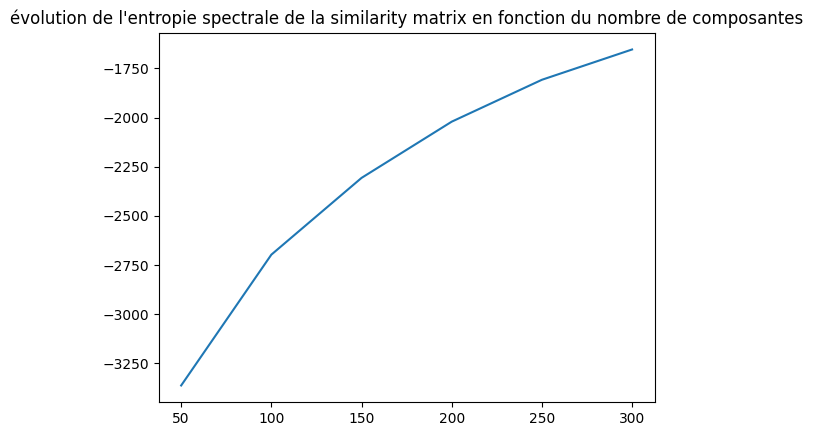

In [79]:
entropy_vect = []
eigen_vect = []
for i in range(50,350,50):
    entropy, eigen = entropy_lsa(X['text'], n_components=i)
    entropy_vect.append(entropy)
    eigen_vect.append(eigen)
    
    print(i)
n_compo = np.arange(50,350,50)

plt.plot(n_compo, entropy_vect)
plt.title("évolution de l'entropie spectrale de la similarity matrix en fonction du nombre de composantes")
plt.show()

(600.0, 1000.0)

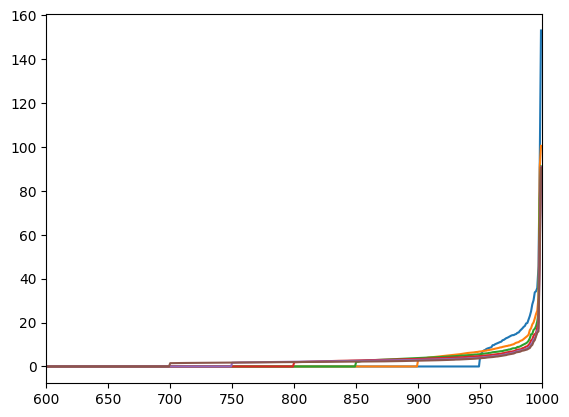

In [74]:
for i in range(6):
    y = np.array(eigen_vect[i])
    t = np.arange(1000)
    plt.plot(t, np.sort(y))

plt.xlim(600,1000)

    

In [ ]:
encoded_test= tokenizer("\n\n".join(data_test["article"][:20]), return_tensors="pt")
perplexity(model, encoded_test, stride=128)